In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg
from os import listdir
from os.path import isfile, join

In [3]:
def get_maximum(A):
    init = A[0]
    for a in A[1:]:
        init = np.maximum(a, init)
    return init

In [9]:
folder = './img_k/'
imgs_files = [f for f in listdir(folder) if isfile(join(folder, f))]
imgs_files

['IMG_20200613_014119.jpg',
 'IMG_20200613_014128.jpg',
 'IMG_20200613_014132.jpg',
 'IMG_20200613_014144.jpg']

In [12]:
imgs = []
for img in imgs_files:
#     imgs.append(cv2.imread(folder + img))
    imgs.append(cv2.cvtColor(cv2.imread(folder + img), cv2.COLOR_BGR2RGB))


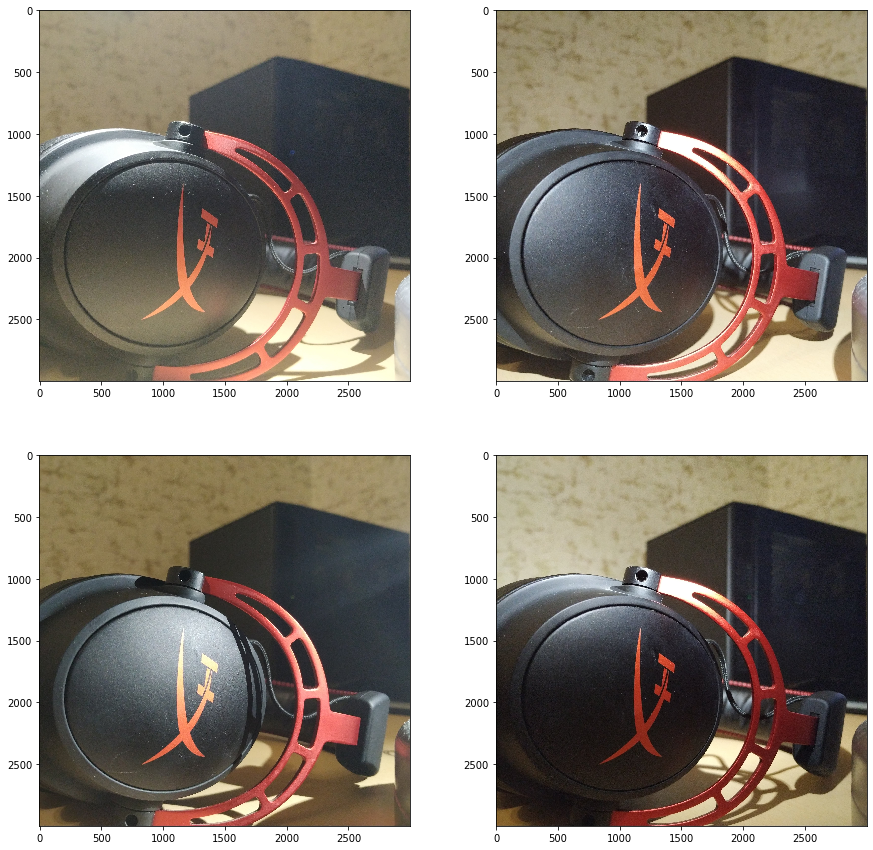

In [14]:
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0,0].imshow(imgs[0])
axarr[0,1].imshow(imgs[1])
axarr[1,0].imshow(imgs[2])
axarr[1,1].imshow(imgs[3])

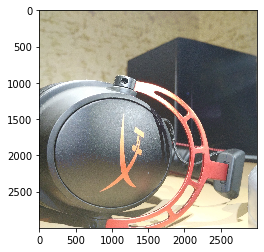

In [15]:
I_colors = defaultdict(list)
for I_k in imgs:
    I = cv2.split(I_k)
    for color, value in enumerate(I):
        I_colors[color].append(value)

max_vals = []
for color in range(3):
    max_v = I_colors[color][0]
    for value in I_colors[color][1:]:
        max_v = np.maximum(max_v, value)
    max_vals.append(max_v)

I_max = cv2.merge(max_vals)
plt.imshow(I_max)

mb sobel

In [16]:
def stats(A):
    return A.dtype, A.shape, np.min(A), np.median(A), np.max(A)

## Calculate intensity gradients $G_k$ gradients of $I_k$. Sobel and numpy

In [17]:
G_sobel_x = []
G_sobel_y = []
G_np_x = []
G_np_y = []
# G = []
for circle in imgs:
    
    sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
    G_sobel_x.append(sobelx)
    G_sobel_y.append(sobely)
    
    print(f"stats X: {stats(sobelx)}")
    print(f"stats Y: {stats(sobely)}")
    
    print("=" * 20)
   
    g_y, g_x, g_z = np.gradient(circle)
    G_np_x.append(g_x)
    G_np_y.append(g_y)    
    
    print(f"g_x : {stats(g_x)}")
    print(f"g_y : {stats(g_y)}")
    
    print("-" * 20)
    



stats X: (dtype('float64'), (3000, 3000, 3), -9052.0, 0.0, 6866.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -8376.0, 0.0, 7801.0)
g_x : (dtype('float64'), (3000, 3000, 3), -105.0, 0.0, 79.0)
g_y : (dtype('float64'), (3000, 3000, 3), -89.5, 0.0, 79.5)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9913.0, -1.0, 8872.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -10367.0, 0.0, 8274.0)
g_x : (dtype('float64'), (3000, 3000, 3), -107.0, 0.0, 108.0)
g_y : (dtype('float64'), (3000, 3000, 3), -106.5, 0.0, 89.0)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9298.0, 2.0, 7378.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -8563.0, -2.0, 8558.0)
g_x : (dtype('float64'), (3000, 3000, 3), -102.5, 0.0, 85.5)
g_y : (dtype('float64'), (3000, 3000, 3), -99.0, 0.0, 88.0)
--------------------
stats X: (dtype('float64'), (3000, 3000, 3), -9456.0, -1.0, 8652.0)
stats Y: (dtype('float64'), (3000, 3000, 3), -9878.0, -2.0, 8948.0)
g_x : (dtype('float64'), (3000,

## $G$ median of gradients ($G(x, y)= median_{k} (G_k(x,y))$). Sobel and numpy

In [18]:
G_sobel_median_x = np.median(G_sobel_x, axis=0)
G_sobel_median_y = np.median(G_sobel_y, axis=0)

G_np_median_x = np.median(G_np_x, axis=0)
G_np_median_y = np.median(G_np_y, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


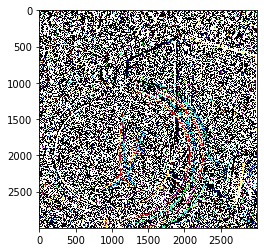

In [42]:
plt.imshow(G_sobel_median_x)

In [ ]:
plt.imshow(G_sobel_median_y)

In [19]:
print(f"sobel_x median: {stats(G_sobel_median_x)}")
print(f"numpy_x median: {stats(G_np_median_x)}")

sobel_x median: (dtype('float64'), (3000, 3000, 3), -7428.0, 0.0, 6214.0)
numpy_x median: (dtype('float64'), (3000, 3000, 3), -79.5, 0.0, 73.0)


## Poisson equation

### divergence of the vector field G

In [20]:
sobelx = cv2.Sobel(G_sobel_median_x,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(G_sobel_median_y,cv2.CV_64F,0,1,ksize=5)
div_G_sobel = sobelx + sobely

x_y, x_x, x_z = np.gradient(G_np_median_x)
y_y, y_x, y_z = np.gradient(G_np_median_y)
div_G_np = x_x + y_y

In [12]:
print(f"div_G_sobel: {stats(div_G_sobel)}")
print(f"div_G_np: {stats(div_G_np)}")

div_G_sobel: (dtype('float64'), (640, 640, 3), -756864.0, 0.0, 491520.0)
div_G_np: (dtype('float64'), (640, 640, 3), -96.0, 0.0, 48.0)


### Solver

In [21]:
def calc_R(alpha, I, I_max):
    return alpha * I + (1 - alpha) * I_max

In [22]:
def solve_poisson(shape, div_G):
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_G.ravel()
    x = ml.solve(b, tol=1e-10)
    print("residual: ", np.linalg.norm(b-A*x)) 
    return x

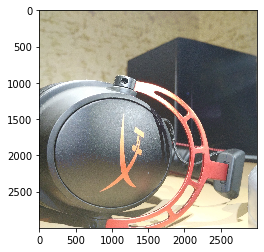

In [23]:
I_max = get_maximum(imgs)
plt.imshow(I_max)

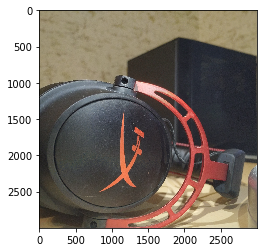

In [24]:
I_median = np.median(imgs, axis=0)
plt.imshow(I_median.astype('uint8'))

#### Full img

In [33]:
shape = imgs[0].shape
size = shape[0]

##### Sobel

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.341
Grid Complexity:      1.573
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0     27000000    170964000 [42.72%]
    1     13500000    202404006 [50.57%]
    2      1538303     20845899 [ 5.21%]
    3       306605      4219445 [ 1.05%]
    4        78147      1179713 [ 0.29%]
    5        28700       406996 [ 0.10%]
    6        10896       133220 [ 0.03%]
    7         4050        39912 [ 0.01%]
    8         1457        11389 [ 0.00%]
    9          523         3405 [ 0.00%]

residual:  0.0003497933442410058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ans: (dtype('float64'), (3000, 3000, 3), -553915.6517900449, 60.5024084092434, 397360.21195400646)
Wall time: 1min 57s


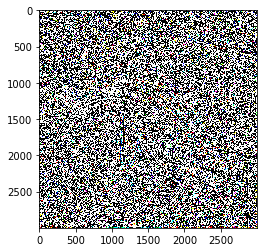

In [34]:
%%time
ans_sobel = solve_poisson(shape, div_G_sobel).reshape(-1, size, 3)
plt.imshow(ans_sobel)
print(f"ans: {stats(ans_sobel)}")

In [30]:
ans_sobel[1]

NameError: name 'ans_sobel' is not defined

#### Numpy

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.340
Grid Complexity:      1.573
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      1228800      7774720 [42.73%]
    1       614400      9195526 [50.54%]
    2        70226       950332 [ 5.22%]
    3        14201       194797 [ 1.07%]
    4         3614        53394 [ 0.29%]
    5         1334        18348 [ 0.10%]
    6          505         5855 [ 0.03%]
    7          182         1620 [ 0.01%]
    8           65          407 [ 0.00%]
    9           22          108 [ 0.00%]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual:  2.5648399040232548e-06
ans: (dtype('float64'), (640, 640, 3), -69.50702044715798, -1.3110876030455452, 47.1200377571974)
Wall time: 4.21 s


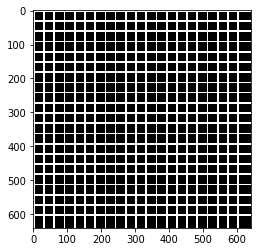

In [19]:
%%time
ans_np = solve_poisson(shape, div_G_np).reshape(-1, size, 3)
plt.imshow(ans_np)
print(f"ans: {stats(ans_np)}")

#### By color img

In [20]:
shape = (size, size)

#### Sobel

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  0.007012695747917715


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  0.007012695747917715


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual:  0.007012695747917715
Sobel by colors ans: (dtype('float64'), (640, 640, 3), -3140722.3041833118, -912925.1457602183, 2725807.721718561)
Wall time: 4.89 s


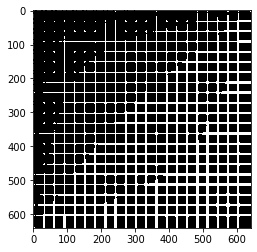

In [21]:
%%time
colors_sobel = cv2.split(div_G_sobel)
ans = []
for color in colors_sobel:
    ans.append(solve_poisson(shape, color).reshape(-1, size))
ans = cv2.merge(ans)
print(f"Sobel by colors ans: {stats(ans)}")
plt.imshow(ans)

In [22]:
ans_sobel, A = solve_poisson(shape, div_G_sobel)

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]



ValueError: dimension mismatch

In [24]:
gray = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)
stats(gray)

(dtype('uint8'), (640, 640), 0, 192.0, 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


stats: (dtype('float64'), (640, 640, 3), -676789.2066221926, 28165.327582393948, 632205.2493605288)


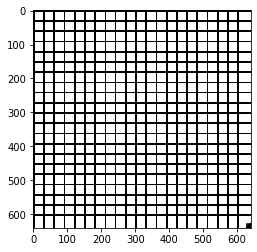

In [21]:
print(f"stats: {stats(-1*ans_sobel)}")
plt.imshow(-1*ans_sobel)

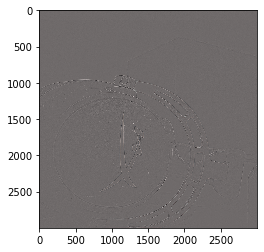

In [35]:
test = np.copy(-1 * ans_sobel)
colors = cv2.split(test)
result = []
for color in colors:
    color -= np.min(color)
    color /= np.max(color) / 255
    color[color > 255] = 255
    color = color.astype('uint8')
    result.append(color)
result = cv2.merge(result)
plt.imshow(result)

R stats: (dtype('float64'), (3000, 3000, 3), 31.200000000000003, 125.4, 254.8)


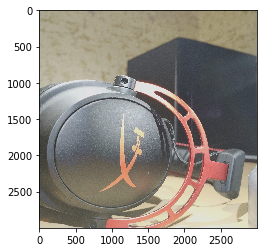

In [39]:
R = calc_R(0.2, result, I_max)
print(f"R stats: {stats(R)}")
plt.imshow(R.astype('uint8'))

R stats: (dtype('float64'), (640, 640, 3), 0.0, 179.09999999999997, 253.2)
Wall time: 41.1 ms


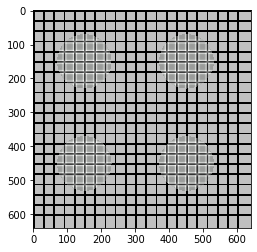

In [60]:
%%time
def calc_R_alpha_channel(alpha, I, I_max, alpha_channel):
    R = np.copy(I_max)
    R[alpha_channel] = alpha * I[alpha_channel] + (1 - alpha) * I_max[alpha_channel]
    return R

R2 = calc_R_alpha_channel(0.8, result, I_max, I_max == 255)
print(f"R stats: {stats(R)}")
plt.imshow(R2.astype('uint8'))